# Login / Switch DEV_TEST_PROD environment (1-timer)

In [3]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
76a2ae5a-9f00-4f6b-95ed-5d33d77c4d61
aml-prj001-weu-DEV-001
b8c1d478-1baa-4204-b54a-364ac29c154d
sog-weu-esml-project001-weu-DEV-001-rg
Performing interactive authentication. Please follow the instructions on the terminal.
Interactive authentication successfully completed.


# 1) ESML - TRAIN Classification, TITANIC model, and DEPLOY with predict_proba scoring

In [1]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.active_model = 11
p.inference_mode = False
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.verbose_logging = False
p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Environment: dev
Inference version: 1

 - ds01_diabetes
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/in/dev/2021/01/01/
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/out/bronze/dev/
projects/project002/11_diabetes_model_reg/train/ds01_diabetes/out/silver/dev/

 - ds02_other
projects/project002/11_diabetes_model_reg/train/ds02_other/in/dev/2021/01/01/
projects/project002/11_diabetes_model_reg/train/ds02_other/out/bronze/dev/
projects/project002/11_diabetes_model_reg/train/ds02_other/out/silver/dev/
 

Training GOLD (p.GoldPath)
projects/project002/11_diabetes_model_reg/train/gold/dev/
 

[A) USAGE]: to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/project002/11_diabetes_model_reg/inference/1/gold/dev/2022_07_31/e8b3d646893c4349a4abbcbfa5f544b1/
 

A)INFERENCE ONLINE: GO

In [3]:
def test_feature_engieering():
    # Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
    esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    esml_dataset2 = p.DatasetByName("ds02_other") # Get dataset
    df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

    df = esml_dataset.Silver.to_pandas_dataframe() 
    df_filtered = df[df.AGE > 0.015] 
    gold = p.save_gold(df_filtered)  #Silver -> Gold
    return gold

In [4]:
datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
gold = test_feature_engieering()

Using GEN2 as Datastore
use_project_sp_2_mount: True
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  2021/01/01
 - INFERENCE in date: 2021/06/08 and ModelVersion to score with: 1 (0=latest)

Inference mode (False = Training mode): False
Load data as Datasets....
ds01_diabetes
ds02_other

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002prjsp 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetNam

In [ ]:
datastore = None
try:
    datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already...and splitted. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

In [5]:
p.Gold.to_pandas_dataframe().head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,0.038076,0.05068,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,0.085299,0.05068,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
2,0.063504,0.05068,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064,63.0
3,0.041708,0.05068,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349,110.0
4,0.027178,0.05068,0.017506,-0.033214,-0.007073,0.045972,-0.065491,0.071210,-0.096433,-0.059067,69.0


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

In [6]:
M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = p.split_gold_3(0.6,stratified=False) # Splits and Auto-registers as AZUREM ML Datasets

...


# IN_2_GOLD
- If just wanting to refine data to GOLD, for a Power BI report (No ML involved)
- Scenario: You want to refine data from "IN_2_GOLD" with an easy way to READ/WRITE data (using the enterprise datalake via ESML AutoLake and ESML SDK)

In [9]:
p.GoldTrain.to_pandas_dataframe().head()  # Azure ML Dataset

,Survived,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare
0,1,1,Mr. Adolphe Saalfeld,male,47.0,0,0,30.5000
1,0,2,Mr. Joseph Philippe Lemercier Laroche,male,25.0,1,2,41.5792
2,0,3,Mr. Samuel Beard Risien,male,69.0,0,0,14.5000
3,1,1,Col. Oberst Alfons Simonius-Blumer,male,56.0,0,0,35.5000
4,0,2,Rev. Charles Leonard Kirkland,male,57.0,0,0,12.3500


# 2) `ESML` Train model in `5 codelines`

In [7]:
automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
automl_performance_config

Loading AutoML config settings from: dev


{'enable_voting_ensemble': True,
 'enable_stack_ensemble': False,
 'model_explainability': True,
 'experiment_timeout_hours': 0.75,
 'iteration_timeout_minutes': 5,
 'n_cross_validations': 3,
 'enable_early_stopping': False,
 'iterations': 100,
 'max_cores_per_iteration': -1,
 'allowed_models': ['LightGBM',
  'AveragedPerceptronClassifier',
  'RandomForest',
  'Xgboost'],
 'path': '.',
 'debug_log': 'azure_automl_debug_dev.log'}

In [8]:
print('Label is: {}'.format(p.active_model["label"]))

Label is: Y


In [9]:
from esml import ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

label = p.active_model["label"]
automl_config = AutoMLConfig(task = 'regression', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_regression.MAE, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.308', # DEMO purpose
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False
# Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster p002-m11weu-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = p002-m11weu-dev
Experiment name: 11_diabetes_model_reg
Azure ML Studio Workspace: aml-prj002-weu-DEV-003
Start training run...
Submitting remote run.
No run_configuration provided, running on p002-m11weu-dev with default configuration
Running 

Experiment,Id,Type,Status,Details Page,Docs Page
11_diabetes_model_reg,AutoML_449698ff-0071-40fb-a2e5-cfa0ad4219d6,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

************************************************************

- ESML has now fetched `configuration & train compute` for enterprise `environment (DEV,TEST or PROD)`
- ESML has `autogenerated` a AutoML-experiment, optinally as `pipline`, in correct environment.
- User has overridden some AutoML settings (`label, split percentage`, `target metric`), and use the `1-liner TRAIN` code snippet 

# 3) Production purpose: "once and only once": Wrap code
- 3 Callers: MLOps, AMLPipeline, and this notebook

import sys
sys.path.insert(0, "../../2_A_aml_pipeline/4_inference/batch/M10/your_code/")
from your_custom_code import M01In2GoldProcessor

#p.init()
esml_dataset1 = p.DatasetByName("ds01_titanic") # Get dataset 1
df_bronze = esml_dataset1.Bronze.to_pandas_dataframe()
silver1 = p.save_silver(esml_dataset1,df_bronze) #Bronze -> Silver

esml_dataset2 = p.DatasetByName("ds02_haircolor") # Get dataset 2
df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
silver2 = p.save_silver(esml_dataset2,df_bronze2) #Bronze -> Silver

df1 = M01In2GoldProcessor().M01_ds01_process_in2silver(silver1.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds01...py"
df2 = M01In2GoldProcessor().M01_ds02_process_in2silver(silver2.to_pandas_dataframe())  # You can then copy this statement in your pipeline-step "in2silver_ds02...py"

merged_gold = M01In2GoldProcessor().M01_merge_silvers(df1,df2) # # You can then copy this statement in your pipeline-step "silver_merged_2_gold.py"
p.save_gold(merged_gold).to_pandas_dataframe().head()

## 2b) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [10]:
from baselayer_azure_ml_model import ESMLModelCompare

current_env = p.dev_test_prod # dev
target_env = "dev" # Does newly trained Model v3 in DEV, score better than Model v2 in TEST?
print("promote model in DEV to TEST? (move to other Azure ML Studio Workspace)")

compare = ESMLModelCompare(p)
promote,source_model_name,new_run_id,target_model_name, target_best_run_id,target_workspace,source_model = compare.compare_scoring_current_vs_new_model(target_env) # Compare DEV to TEST (or TEST to PROD)  (1min, 17sek VS 33sec)

print("SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD \n")
print("New Model: {} in environment {}".format(target_model_name, p.dev_test_prod))
print("Existing Model: {} in environment {}".format(source_model_name,target_env))

if (promote): # Can register="promote" a model in same workspace (test->test), or also register in OTHER Azure ML workspace (test->prod)
    if(p.dev_test_prod == target_env):
        compare.register_active_model(target_env,source_model) # if SAME workspace this brings more "metadata" faster to the model registration
    else:
        compare.register_model_in_correct_ws(target_env) # if REMOTE target workspace we can get same metadata, BUT, just takes performancewise longer. More lookups to "source Run"

promote model in DEV to TEST? (move to other Azure ML Studio Workspace)
target=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)

new_run_id AutoML_449698ff-0071-40fb-a2e5-cfa0ad4219d6
active_model_config from 'automl_active_model_env.json': source_model_name: AutoML449698ff00
Could not find EXISTING MODEL with same experiment name = No TARGET run. This is the first model to be trained in environment: dev, nothing to compare against -> Go ahead and register & deploy new model
TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
target_best_run_id AutoML_a4ff3bbd-df5a-41fe-89e6-bef8f437b315
SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD 

New Model: AutoMLa4ff3bbdd0 in environment dev
Existing Model: AutoML449698ff00 in environment dev
model.version 1
Model name AutoML4496

# TEST SET SCORING

# Test-set: Ensure we have a TEST_SET splitted

label = p.active_model["label"]
try:
    p.GoldTest.name
except: 
    p.connect_to_lake() # p.init() + automap
    train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6)

### NOW we can calcualate scoring on TEST_SET

...
...
Replacing tag run_id -> AutoML_449698ff-0071-40fb-a2e5-cfa0ad4219d6 with run_id -> AutoML_449698ff-0071-40fb-a2e5-cfa0ad4219d6
Replacing tag model_name -> AutoML449698ff00 with model_name -> AutoML449698ff00
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> aml-prj002-weu-DEV-003 with trained_in_workspace -> aml-prj002-weu-DEV-003
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag test_set_RMSE -> 57.085702 with test_set_RMSE -> 57.085702
Replacing tag test_set_R2 -> 0.321046 with test_set_R2 -> 0.321046
Replacing tag test_set_MAPE -> 0.272820 with test_set_MAPE -> 0.272820
Replacing tag test_set_Spearman_Correlation -> 0.593598 with test_set_Spearman_Correlation -> 0.593598
Model tag add operation complete.
RMSE:
57.08570225185653

R2:
0.32104609233321757

MAPE:
0.27282048085206756

MAE:
45.332440980500316

Spearman:
0.5935981073131724


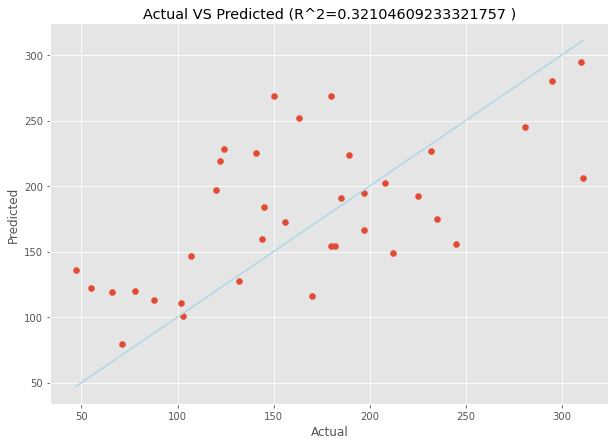

In [11]:
from baselayer_azure_ml import ESMLTestScoringFactory

label = p.active_model["label"]
rmse, r2, mean_abs_percent_error,mae,spearman_corr,plt = ESMLTestScoringFactory(p).get_test_scoring_4_regression(label)
print("RMSE:")
print(rmse)
print()
print("R2:")
print(r2)
print()
print("MAPE:")
print(mean_abs_percent_error)
print()
print("MAE:")
print(mae)
print()
print("Spearman:")
print(spearman_corr)

# 3) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [31]:
inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,overwrite_endpoint=True) # Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Loading AutoML config settings from: dev
Deploying model: AutoML4b3c03dfe18 with verison: 7 to environment: dev with overwrite_endpoint=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
image_build_compute = prj02-m10-dev
Found existing AksWebservice endpoint, deleting it, since overwrite=True
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster, esml-dev-prj02, using it.
Note: Autoscale_enabled=False, or since aks_dev_test=True in config, autoscaling is automatically shut off, e.g. overridden in config (since n

## 3b) DEPLOY TEST with ESML `2 lines of code`

In [32]:
p.connect_to_lake()
X_test, y_test, tags = p.get_gold_validate_Xy()
print(tags)
caller_id = "10965d9c-40ca-4e47-9723-5a608a32a0e4"

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found in LAKE. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
Path for active folder (where no files exists):
AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/10_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID '47ec4490-b44c-492f-9dc2-65be5c34a11e', request ID '78d8a4db-801f-005b-4382-ec59eb000000
M10_GOLD_VALIDATE : (177, 8)
X_test  (177, 7)
y_test  (177,)
{'split_percentage': '0.2', 'label': 'Survived', 'model': '10_titanic_model_clas'}


In [6]:
df = p.call_webservice(p.ws, X_test,caller_id) 
df.head()

Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found in LAKE. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings
Path for active folder (where no files exists):
AdlsGen2-ListFiles (req=1, existingItems=0)' for 'https://msftweudevcmnai2.dfs.core.windows.net/lake3?directory=projects/project002/10_titanic_model_clas/train/active&recursive=true&resource=filesystem' on storage failed with status code 'NotFound' (The specified path does not exist.), client request ID 'd11f07e2-412f-49fd-aed8-f8d07664bfb3', request ID 'a471feb8-501f-0005-1b65-d7b20b000000
M10_GOLD_VALIDATE : (89, 8)
X_test  (89, 7)
y_test  (89,)
{'split_percentage': '0.1', 'label': 'Survived', 'model': '10_titanic_model_clas'}
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_set

,Pclass,Name,Sex,Age,Siblings_Spouses Aboard,Parents_Children Aboard,Fare,result
0,3,Mr. Sahid Nakid,male,20.00,1,1,15.74,0
1,3,Mr. Hanna Assi Barah,male,20.00,0,0,7.23,0
2,3,Mr. Edward Willey,male,21.00,0,0,7.55,0
3,2,Master. Viljo Hamalainen,male,0.67,1,1,14.50,1
4,3,Mrs. Guillaume Joseph (Emma) de Messemaeker,female,36.00,1,0,17.40,1


# END